# 10. Final Evaluation & Business Decision

---

## 1. Objective & Scope

This notebook performs the **final evaluation** of the selected Logistic Regression model using a **proper validation-first threshold selection** and a **single final test evaluation**.

**What this notebook does:**
- Evaluate the frozen model on **validation data** to analyze thresholds
- Select an optimal threshold based on business constraints (validation only)
- Evaluate **once** on the test set with the chosen threshold
- Provide executive-ready recommendations

**What this notebook does NOT do:**
- No training or re-training
- No hyperparameter tuning
- No feature engineering or modification
- No changes to the model

All artifacts are **frozen** from previous notebooks.


---

## 2. Load Artifacts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import os
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
# =====================================================
# Notebook location (we are inside /notebooks)
# =====================================================

PROJECT_ROOT = Path.cwd().parent

MODELS_PATH = PROJECT_ROOT / "models"
DATA_PROCESSED_PATH = PROJECT_ROOT / "data" / "processed"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("MODELS_PATH exists:", MODELS_PATH.exists())
print("DATA_PROCESSED_PATH exists:", DATA_PROCESSED_PATH.exists())

# =====================================================
# Load frozen artifacts
# =====================================================
model = joblib.load(MODELS_PATH / "best_model.joblib")
print("Model loaded")

preprocessor = joblib.load(MODELS_PATH / "preprocessor.joblib")
print("Preprocessor loaded")

X_val_processed = np.load(DATA_PROCESSED_PATH / "X_val_processed.npy")
y_val = np.load(DATA_PROCESSED_PATH / "y_val.npy")
print("Validation data loaded:", X_val_processed.shape, y_val.shape)

X_test_processed = np.load(DATA_PROCESSED_PATH / "X_test_processed.npy")
y_test = np.load(DATA_PROCESSED_PATH / "y_test.npy")
print("Test data loaded:", X_test_processed.shape, y_test.shape)

feature_names = pd.read_csv(
    MODELS_PATH / "final_feature_names.csv"
)["feature_name"].tolist()
print(f"Feature names loaded ({len(feature_names)})")


PROJECT_ROOT: /Users/omarpiro/ML_DL_Projects/churn_ml_decision
MODELS_PATH exists: True
DATA_PROCESSED_PATH exists: True
Model loaded
Preprocessor loaded
Validation data loaded: (1409, 31) (1409,)
Test data loaded: (1409, 31) (1409,)
Feature names loaded (31)


In [3]:
# Validation checks
print("=" * 50)
print("ARTIFACT VALIDATION")
print("=" * 50)

# Check shapes (validation)
assert X_val_processed.shape[0] == y_val.shape[0], "Validation sample mismatch!"
print(f"Val shapes consistent: {X_val_processed.shape[0]} samples")

# Check shapes (test)
assert X_test_processed.shape[0] == y_test.shape[0], "Test sample mismatch!"
print(f"Test shapes consistent: {X_test_processed.shape[0]} samples")

# Check for NaN
nan_val = np.isnan(X_val_processed).sum()
assert nan_val == 0, f"Found {nan_val} NaN values in validation!"
print("No NaN values in validation data")

nan_test = np.isnan(X_test_processed).sum()
assert nan_test == 0, f"Found {nan_test} NaN values in test!"
print("No NaN values in test data")

# Check feature alignment
assert X_val_processed.shape[1] == len(feature_names), "Feature count mismatch (val)!"
assert X_test_processed.shape[1] == len(feature_names), "Feature count mismatch (test)!"
print(f"Features aligned: {X_test_processed.shape[1]} features")

# Check target distribution
print(f"Validation churn rate: {y_val.mean():.1%}")
print(f"Test churn rate: {y_test.mean():.1%}")

print("\n" + "=" * 50)
print("ALL CHECKS PASSED - Ready for evaluation")
print("=" * 50)


ARTIFACT VALIDATION
Val shapes consistent: 1409 samples
Test shapes consistent: 1409 samples
No NaN values in validation data
No NaN values in test data
Features aligned: 31 features
Validation churn rate: 26.5%
Test churn rate: 26.5%

ALL CHECKS PASSED - Ready for evaluation


---

## 3. Validation Set Baseline (Threshold = 0.5)

We start with the standard threshold of 0.5 as a **neutral, academic baseline** on the **validation set**. This provides a reference point before any business-driven threshold optimization.


In [4]:
# Generate predictions (validation)
y_val_proba = model.predict_proba(X_val_processed)[:, 1]
y_val_pred_05 = (y_val_proba >= 0.5).astype(int)

# Calculate metrics at threshold 0.5
roc_auc_val = roc_auc_score(y_val, y_val_proba)
precision_05 = precision_score(y_val, y_val_pred_05)
recall_05 = recall_score(y_val, y_val_pred_05)
f1_05 = f1_score(y_val, y_val_pred_05)

print("=" * 50)
print("VALIDATION SET PERFORMANCE (Threshold = 0.5)")
print("=" * 50)
print(f"ROC-AUC Score:  {roc_auc_val:.4f}")
print(f"Precision:      {precision_05:.4f}")
print(f"Recall:         {recall_05:.4f}")
print(f"F1 Score:       {f1_05:.4f}")
print("=" * 50)


VALIDATION SET PERFORMANCE (Threshold = 0.5)
ROC-AUC Score:  0.8611
Precision:      0.5330
Recall:         0.8209
F1 Score:       0.6463


In [5]:
# Classification Report
print("\nClassification Report (Validation,Threshold = 0.5):\n")
print(classification_report(y_val, y_val_pred_05, 
                            target_names=['No Churn', 'Churn']))


Classification Report (Validation,Threshold = 0.5):

              precision    recall  f1-score   support

    No Churn       0.92      0.74      0.82      1035
       Churn       0.53      0.82      0.65       374

    accuracy                           0.76      1409
   macro avg       0.73      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409



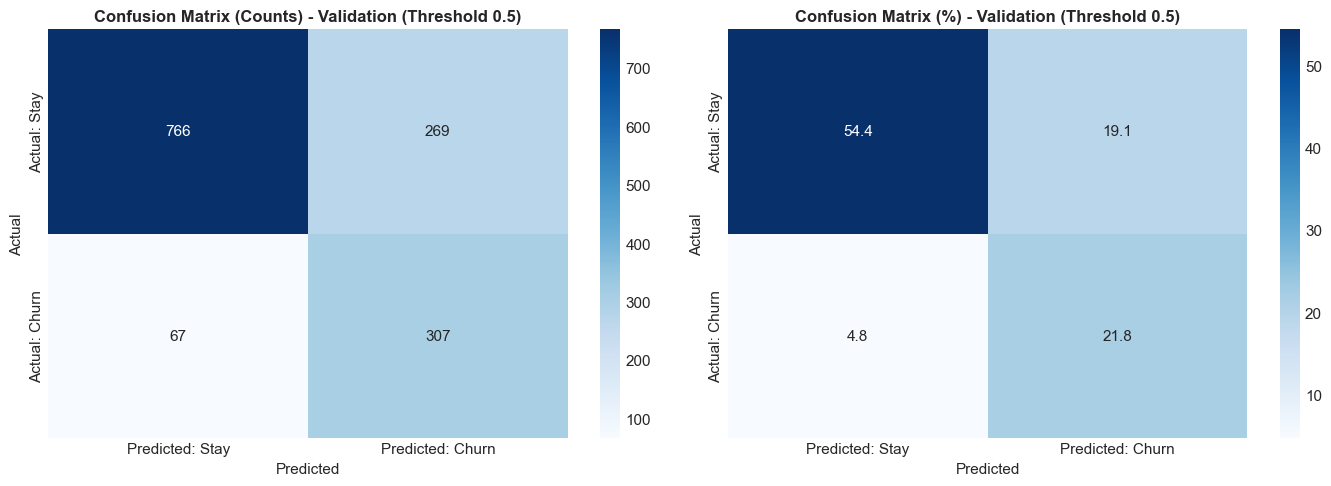


Baseline Summary (Validation, Threshold = 0.5):
  True Negatives (correctly identified as staying): 766
  False Positives (incorrectly flagged as churning): 269


In [6]:
# Confusion Matrix at threshold 0.5 (validation)
cm_05 = confusion_matrix(y_val, y_val_pred_05)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute values
sns.heatmap(cm_05, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Predicted: Stay', 'Predicted: Churn'],
            yticklabels=['Actual: Stay', 'Actual: Churn'])
axes[0].set_title('Confusion Matrix (Counts) - Validation (Threshold 0.5)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Percentages
cm_05_pct = cm_05.astype('float') / cm_05.sum() * 100
sns.heatmap(cm_05_pct, annot=True, fmt='.1f', cmap='Blues', ax=axes[1],
            xticklabels=['Predicted: Stay', 'Predicted: Churn'],
            yticklabels=['Actual: Stay', 'Actual: Churn'])
axes[1].set_title('Confusion Matrix (%) - Validation (Threshold 0.5)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# Extract values for interpretation
tn, fp, fn, tp = cm_05.ravel()
print(f"\nBaseline Summary (Validation, Threshold = 0.5):")
print(f"  True Negatives (correctly identified as staying): {tn}")
print(f"  False Positives (incorrectly flagged as churning): {fp}")


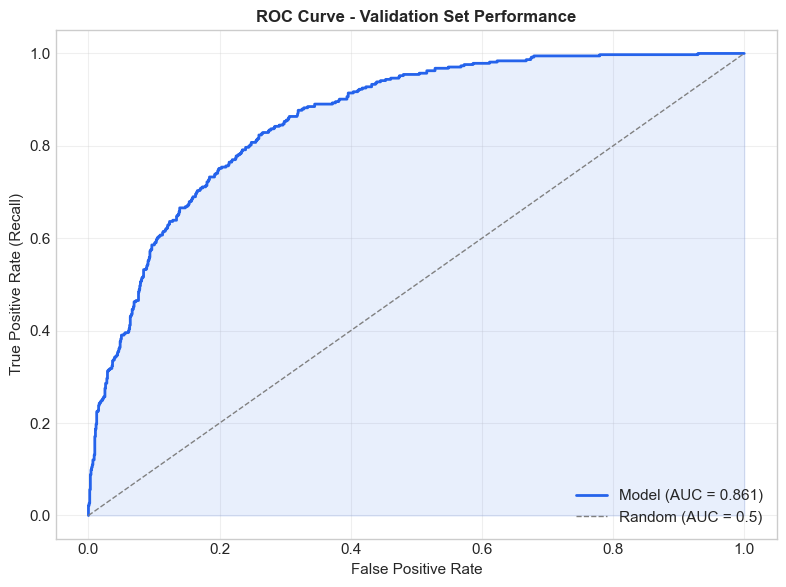

In [7]:
# ROC Curve (validation)
fpr, tpr, thresholds_roc = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#2563eb', lw=2, label=f'Model (AUC = {roc_auc_val:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Random (AUC = 0.5)')
plt.fill_between(fpr, tpr, alpha=0.1, color='#2563eb')
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate (Recall)', fontsize=11)
plt.title('ROC Curve - Validation Set Performance', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Baseline Interpretation:**

At the standard threshold of 0.5, the model provides a balanced view. However, business requirements may favor either higher recall (catching more churners) or higher precision (fewer false alarms). The next section explores this trade-off.

---

## 4. Business-Oriented Threshold Analysis

The decision threshold determines the **trade-off between catching churners and minimizing false alarms**. Different business contexts require different thresholds:

- **Lower threshold (e.g., 0.3)**: Catch more churners, but more false positives (costly retention offers to non-churners)
- **Higher threshold (e.g., 0.7)**: Fewer false positives, but miss more actual churners

In [ ]:
# =====================================================
# Business parameters (from config/default.yaml)
# =====================================================
RETAINED_VALUE = 600.0  # CLV * success_rate = 2000 * 0.30
CONTACT_COST = 50.0

# Constraints for threshold selection
MIN_RECALL = 0.70
MIN_PRECISION = 0.50

# Analyze performance across multiple thresholds (validation)
# Keep in sync with src/churn_ml_decision/evaluate.py
thresholds = np.arange(0.2, 0.85 + 1e-9, 0.05)
thresholds = np.round(thresholds, 2)

threshold_analysis = []

for thresh in thresholds:
    y_pred_thresh = (y_val_proba >= thresh).astype(int)

    # Calculate metrics
    cm = confusion_matrix(y_val, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()

    precision = precision_score(y_val, y_pred_thresh, zero_division=0)
    recall = recall_score(y_val, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_val, y_pred_thresh, zero_division=0)

    # Business metrics
    total_churners = tp + fn
    total_non_churners = tn + fp
    churners_captured_pct = (tp / total_churners * 100) if total_churners > 0 else 0
    false_positive_rate = (fp / total_non_churners * 100) if total_non_churners > 0 else 0
    total_flagged = tp + fp

    # Net Value calculation: value from retained churners minus contact costs
    net_value = tp * RETAINED_VALUE - total_flagged * CONTACT_COST

    threshold_analysis.append({
        'Threshold': float(thresh),
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'True_Positives': tp,
        'False_Positives': fp,
        'False_Negatives': fn,
        'True_Negatives': tn,
        'Churners_Captured_%': churners_captured_pct,
        'False_Positive_Rate_%': false_positive_rate,
        'Total_Flagged': total_flagged,
        'Net_Value': net_value,
        'Net_per_Flagged': net_value / total_flagged if total_flagged > 0 else 0.0
    })

# Convert to DataFrame
df_threshold = pd.DataFrame(threshold_analysis)
print(f"Business parameters: retained_value={RETAINED_VALUE}, contact_cost={CONTACT_COST}")
print(f"Constraints: min_recall={MIN_RECALL}, min_precision={MIN_PRECISION}")

In [9]:
# Display threshold analysis table with Net_Value
display_cols = ['Threshold', 'Precision', 'Recall', 'F1_Score', 
                'Churners_Captured_%', 'False_Positive_Rate_%', 'Total_Flagged', 'Net_Value']

print("=" * 100)
print("THRESHOLD ANALYSIS - Business Metrics with Net Value")
print("=" * 100)
print(df_threshold[display_cols].to_string(index=False))
print("=" * 100)
print(f"\nNet_Value = (True_Positives * {RETAINED_VALUE}) - (Total_Flagged * {CONTACT_COST})")

THRESHOLD ANALYSIS - Business Metrics with Net Value
 Threshold  Precision   Recall  F1_Score  Churners_Captured_%  False_Positive_Rate_%  Total_Flagged  Net_Value
      0.20   0.386994 0.970588  0.553354            97.058824              55.555556            938   170900.0
      0.25   0.403608 0.957219  0.567803            95.721925              51.111111            887   170450.0
      0.30   0.425993 0.946524  0.587552            94.652406              46.086957            831   170850.0
      0.35   0.444588 0.922460  0.600000            92.245989              41.642512            776   168200.0
      0.40   0.475036 0.890374  0.619535            89.037433              35.555556            701   164750.0
      0.45   0.503912 0.860963  0.635735            86.096257              30.628019            639   161250.0
      0.50   0.532986 0.820856  0.646316            82.085561              25.990338            576   155400.0
      0.55   0.554493 0.775401  0.646600            77.5401

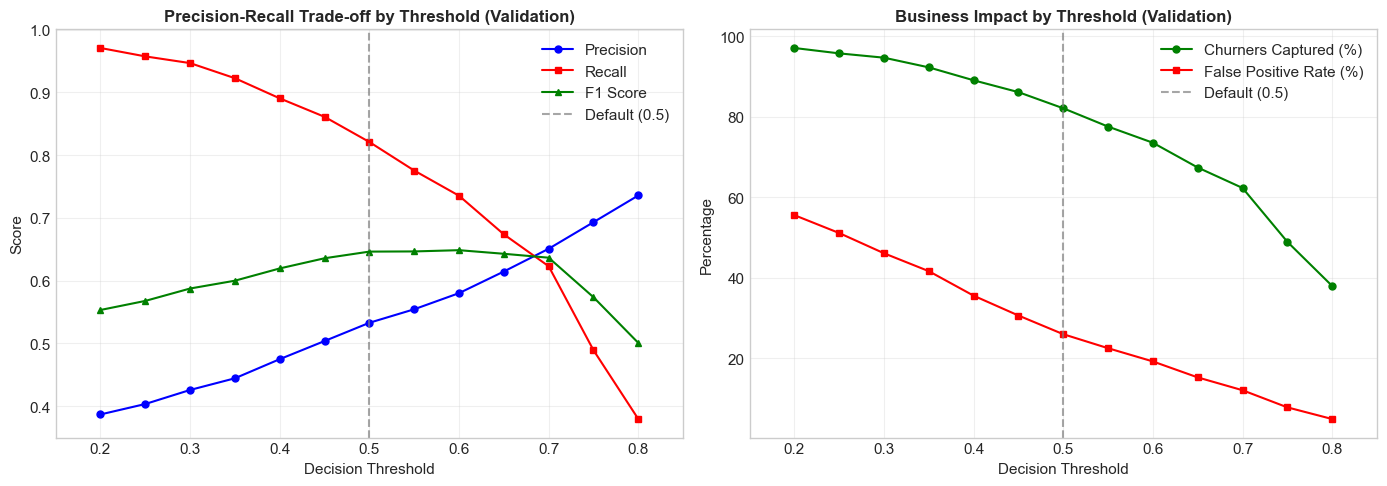

In [10]:
# Visualize Precision-Recall Trade-off
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision, Recall, F1 vs Threshold
axes[0].plot(df_threshold['Threshold'], df_threshold['Precision'], 
             'b-o', label='Precision', markersize=5)
axes[0].plot(df_threshold['Threshold'], df_threshold['Recall'], 
             'r-s', label='Recall', markersize=5)
axes[0].plot(df_threshold['Threshold'], df_threshold['F1_Score'], 
             'g-^', label='F1 Score', markersize=5)
axes[0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Default (0.5)')
axes[0].set_xlabel('Decision Threshold', fontsize=11)
axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('Precision-Recall Trade-off by Threshold (Validation)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0.15, 0.85)

# Plot 2: Business Metrics
axes[1].plot(df_threshold['Threshold'], df_threshold['Churners_Captured_%'], 
             'g-o', label='Churners Captured (%)', markersize=5)
axes[1].plot(df_threshold['Threshold'], df_threshold['False_Positive_Rate_%'], 
             'r-s', label='False Positive Rate (%)', markersize=5)
axes[1].axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Default (0.5)')
axes[1].set_xlabel('Decision Threshold', fontsize=11)
axes[1].set_ylabel('Percentage', fontsize=11)
axes[1].set_title('Business Impact by Threshold (Validation)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0.15, 0.85)

plt.tight_layout()
plt.show()


In [11]:
# Key threshold comparison (robust to float issues)
key_thresholds = [0.3, 0.4, 0.5, 0.6]
print("\n" + "=" * 70)
print("KEY THRESHOLD COMPARISON")
print("=" * 70)

for thresh in key_thresholds:
    idx = (df_threshold['Threshold'] - thresh).abs().idxmin()
    row = df_threshold.loc[idx]
    print(f"\nThreshold {row['Threshold']:.2f} (closest to {thresh}):")
    print(f"  -> Captures {row['Churners_Captured_%']:.1f}% of churners")
    print(f"  -> False positive rate: {row['False_Positive_Rate_%']:.1f}%")
    print(f"  -> Total customers flagged: {int(row['Total_Flagged'])}")
    print(f"  -> F1 Score: {row['F1_Score']:.3f}")



KEY THRESHOLD COMPARISON

Threshold 0.30 (closest to 0.3):
  -> Captures 94.7% of churners
  -> False positive rate: 46.1%
  -> Total customers flagged: 831
  -> F1 Score: 0.588

Threshold 0.40 (closest to 0.4):
  -> Captures 89.0% of churners
  -> False positive rate: 35.6%
  -> Total customers flagged: 701
  -> F1 Score: 0.620

Threshold 0.50 (closest to 0.5):
  -> Captures 82.1% of churners
  -> False positive rate: 26.0%
  -> Total customers flagged: 576
  -> F1 Score: 0.646

Threshold 0.60 (closest to 0.6):
  -> Captures 73.5% of churners
  -> False positive rate: 19.2%
  -> Total customers flagged: 474
  -> F1 Score: 0.649


---

## 5. Threshold Selection (Decision)

### Business Context

For a **customer retention campaign**, we optimize for **Net Value** - the expected profit from the retention campaign:

```
Net_Value = (True_Positives × Retained_Value) - (Total_Flagged × Contact_Cost)
```

Where:
- **Retained_Value** = CLV × Success_Rate = $2000 × 30% = $600 per successfully retained customer
- **Contact_Cost** = $50 per customer contacted

### Selection Strategy

The production pipeline (`churn-evaluate`) uses the following logic:

1. **Filter** thresholds where `Recall >= min_recall` (catch enough churners)
2. **Filter** thresholds where `Precision >= min_precision` (maintain quality gate)
3. **Select** the threshold with the **highest Net_Value** among candidates

This approach maximizes business profit while respecting operational constraints.

In [ ]:
# =====================================================
# Threshold Selection: Maximize Net_Value with constraints
# =====================================================

# Apply constraints
candidates = df_threshold[
    (df_threshold['Recall'] >= MIN_RECALL) &
    (df_threshold['Precision'] >= MIN_PRECISION)
]

print("=" * 70)
print("THRESHOLD SELECTION ANALYSIS")
print("=" * 70)

if candidates.empty:
    print()
    print("No threshold meets both constraints:")
    print(f"  - Recall >= {MIN_RECALL:.0%}")
    print(f"  - Precision >= {MIN_PRECISION:.0%}")
    print()
    print("Falling back to best F1 score...")
    best_idx = df_threshold['F1_Score'].idxmax()
    recommended_threshold = float(round(df_threshold.loc[best_idx, 'Threshold'], 2))
    selection_reason = "Best F1 on validation (fallback)"
else:
    print()
    print(f"Candidates meeting constraints (Recall >= {MIN_RECALL:.0%}, Precision >= {MIN_PRECISION:.0%}):")
    print(candidates[['Threshold', 'Recall', 'Precision', 'Net_Value']].to_string(index=False))

    # Select threshold with highest Net_Value
    best_idx = candidates['Net_Value'].idxmax()
    recommended_threshold = float(round(candidates.loc[best_idx, 'Threshold'], 2))
    selection_reason = f"Best Net_Value on validation (Recall >= {MIN_RECALL:.0%} & Precision >= {MIN_PRECISION:.0%})"

print()
print(f"Selected threshold: {recommended_threshold:.2f}")
print(f"Selection reason: {selection_reason}")

In [ ]:
# FINAL THRESHOLD DECISION (from validation analysis)
FINAL_THRESHOLD = float(round(recommended_threshold, 2))

# Robust lookup in case of float representation differences
final_idx = (df_threshold['Threshold'] - FINAL_THRESHOLD).abs().idxmin()
final_row = df_threshold.loc[final_idx]

print()
print('=' * 70)
print('FINAL THRESHOLD SELECTED')
print('=' * 70)
print()
print(f'Threshold: {FINAL_THRESHOLD:.2f}')
print(f'Selection: {selection_reason}')
print()
print('Validation Metrics:')
print(f"  - Recall: {final_row['Recall']:.1%} (captures {final_row['Churners_Captured_%']:.1f}% of churners)")
print(f"  - Precision: {final_row['Precision']:.1%}")
print(f"  - F1 Score: {final_row['F1_Score']:.3f}")
print(f"  - False Positive Rate: {final_row['False_Positive_Rate_%']:.1f}%")
print(f"  - Total Flagged: {int(final_row['Total_Flagged'])}")
print()
print('Business Impact (validation):')
print(f"  - Net Value: ${final_row['Net_Value']:,.0f}")
print('=' * 70)

---

## 6. Final Model Performance (Chosen Threshold)

Definitive results using the selected business threshold.

In [ ]:
# Final predictions with chosen threshold (TEST SET)
y_test_proba = model.predict_proba(X_test_processed)[:, 1]
y_test_pred_final = (y_test_proba >= FINAL_THRESHOLD).astype(int)

# Final metrics (test)
roc_auc_test = roc_auc_score(y_test, y_test_proba)
final_precision = precision_score(y_test, y_test_pred_final)
final_recall = recall_score(y_test, y_test_pred_final)
final_f1 = f1_score(y_test, y_test_pred_final)

# Final confusion matrix
cm_final = confusion_matrix(y_test, y_test_pred_final)
tn_f, fp_f, fn_f, tp_f = cm_final.ravel()

print("=" * 60)
print(f"FINAL PERFORMANCE (TEST SET, Threshold = {FINAL_THRESHOLD:.2f})")
print("=" * 60)
print()
print("Model Metrics:")
print(f"  ROC-AUC:    {roc_auc_test:.4f}  (threshold-independent)")
print(f"  Precision:  {final_precision:.4f}")
print(f"  Recall:     {final_recall:.4f}")
print(f"  F1 Score:   {final_f1:.4f}")
print("=" * 60)

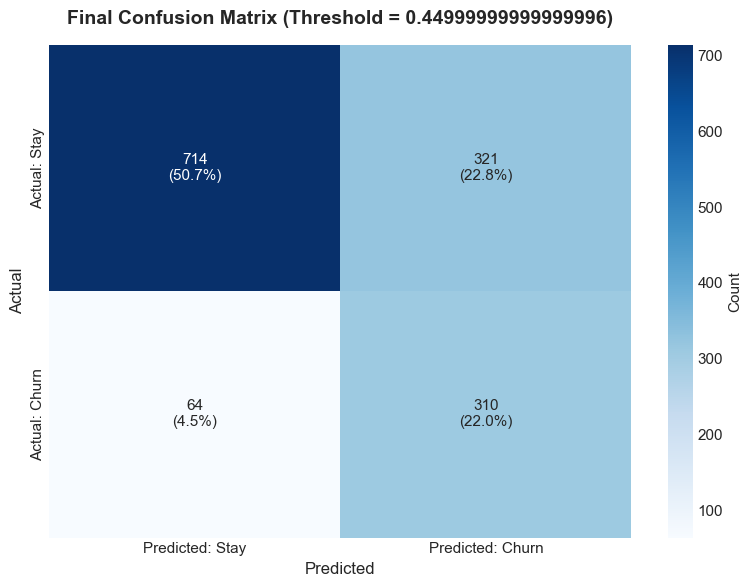

In [15]:
# Final Confusion Matrix Visualization
fig, ax = plt.subplots(figsize=(8, 6))

# Create labels with both counts and percentages
total = cm_final.sum()
labels = np.array([
    [f'{tn_f}\n({tn_f/total*100:.1f}%)', f'{fp_f}\n({fp_f/total*100:.1f}%)'],
    [f'{fn_f}\n({fn_f/total*100:.1f}%)', f'{tp_f}\n({tp_f/total*100:.1f}%)']
])

sns.heatmap(cm_final, annot=labels, fmt='', cmap='Blues', ax=ax,
            xticklabels=['Predicted: Stay', 'Predicted: Churn'],
            yticklabels=['Actual: Stay', 'Actual: Churn'],
            cbar_kws={'label': 'Count'})
ax.set_title(f'Final Confusion Matrix (Threshold = {FINAL_THRESHOLD})', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Actual', fontsize=12)
ax.set_xlabel('Predicted', fontsize=12)

plt.tight_layout()
plt.show()

In [16]:
# Business KPIs
total_customers = len(y_test)
total_actual_churners = int(y_test.sum())
total_actual_non_churners = total_customers - total_actual_churners

print("=" * 60)
print("BUSINESS KPIs - FINAL RESULTS")
print("=" * 60)
print(f"\nTest Set Size: {total_customers} customers")
print(f"Actual Churners: {total_actual_churners} ({total_actual_churners/total_customers*100:.1f}%)")
print(f"Actual Non-Churners: {total_actual_non_churners} ({total_actual_non_churners/total_customers*100:.1f}%)")

print(f"\n" + "-" * 60)
print("MODEL OUTCOMES:")
print("-" * 60)

print(f"\n✅ CHURNERS CORRECTLY IDENTIFIED: {tp_f}")
print(f"   → {tp_f/total_actual_churners*100:.1f}% of all actual churners")
print(f"   → These customers can receive retention offers")

print(f"\n❌ CHURNERS MISSED (False Negatives): {fn_f}")
print(f"   → {fn_f/total_actual_churners*100:.1f}% of actual churners")
print(f"   → These customers will likely churn without intervention")

print(f"\n⚠️  FALSE ALARMS (False Positives): {fp_f}")
print(f"   → {fp_f/total_actual_non_churners*100:.1f}% of non-churners")
print(f"   → Retention offers sent unnecessarily")

print(f"\n✅ CORRECTLY IDENTIFIED AS STAYING: {tn_f}")
print(f"   → {tn_f/total_actual_non_churners*100:.1f}% of non-churners")

print(f"\n" + "-" * 60)
print("CAMPAIGN EFFICIENCY:")
print("-" * 60)
total_flagged = tp_f + fp_f
efficiency = tp_f / total_flagged * 100 if total_flagged > 0 else 0
print(f"Total customers flagged for retention: {total_flagged}")
print(f"Campaign precision (true churners among flagged): {efficiency:.1f}%")
print("=" * 60)

# Quality gate check (test set)
QUALITY_MIN_ROC_AUC = 0.83
QUALITY_MIN_RECALL = 0.70
QUALITY_MIN_PRECISION = 0.45

quality_gate_failures = []
if roc_auc_test < QUALITY_MIN_ROC_AUC:
    quality_gate_failures.append('roc_auc')
if final_recall < QUALITY_MIN_RECALL:
    quality_gate_failures.append('recall')
if final_precision < QUALITY_MIN_PRECISION:
    quality_gate_failures.append('precision')

quality_gate_status = 'PASS' if not quality_gate_failures else 'FAIL'
quality_gate_details = ', '.join(quality_gate_failures) if quality_gate_failures else 'none'
print(f"Quality gates (test): {quality_gate_status}")
print(f"Failed gates: {quality_gate_details}")

BUSINESS KPIs - FINAL RESULTS

Test Set Size: 1409 customers
Actual Churners: 374 (26.5%)
Actual Non-Churners: 1035 (73.5%)

------------------------------------------------------------
MODEL OUTCOMES:
------------------------------------------------------------

✅ CHURNERS CORRECTLY IDENTIFIED: 310
   → 82.9% of all actual churners
   → These customers can receive retention offers

❌ CHURNERS MISSED (False Negatives): 64
   → 17.1% of actual churners
   → These customers will likely churn without intervention

⚠️  FALSE ALARMS (False Positives): 321
   → 31.0% of non-churners
   → Retention offers sent unnecessarily

✅ CORRECTLY IDENTIFIED AS STAYING: 714
   → 69.0% of non-churners

------------------------------------------------------------
CAMPAIGN EFFICIENCY:
------------------------------------------------------------
Total customers flagged for retention: 631
Campaign precision (true churners among flagged): 49.1%


---

## 7. Business Interpretation

### What the Model Can Do

This churn prediction model enables the business to:

1. **Identify at-risk customers proactively** before they leave, allowing timely intervention
2. **Prioritize retention resources** on customers most likely to churn
3. **Quantify churn risk** with probability scores for each customer
4. **Segment customers** based on churn likelihood for differentiated strategies

### What the Model Cannot Do

1. **Guarantee 100% accuracy** - Some churners will be missed, some non-churners will be flagged
2. **Explain individual decisions fully** - It predicts likelihood, not certainty
3. **Replace business judgment** - Human review is still valuable for high-value customers
4. **Adapt automatically** - Model should be retrained periodically as customer behavior evolves

### When to Use This Model

- **Monthly/Quarterly retention campaigns**: Score all customers and target top-risk segment
- **Trigger-based interventions**: Flag customers crossing a risk threshold for immediate outreach
- **Resource allocation**: Assign retention specialists to highest-risk accounts
- **Customer segmentation**: Combine churn risk with customer value for prioritization

### Risks & Limitations

| Risk | Mitigation |
|------|------------|
| Model drift over time | Schedule quarterly performance reviews and retraining |
| Over-reliance on predictions | Combine with human judgment for high-value customers |
| Privacy concerns | Ensure compliance with data protection regulations |
| False positive fatigue | Monitor campaign response rates and adjust threshold if needed |

In [ ]:
# Executive Summary Card
print()
print("#" * 70)
print("#" + " " * 68 + "#")
print("#" + "         EXECUTIVE SUMMARY - CHURN PREDICTION MODEL".center(68) + "#")
print("#" + " " * 68 + "#")
print("#" * 70)

print(f"""
MODEL PERFORMANCE:
  - Overall discriminative power (ROC-AUC): {roc_auc_test:.1%}
  - Churner detection rate: {final_recall:.1%}
  - Prediction accuracy when flagging churn: {final_precision:.1%}

BUSINESS IMPACT (per {total_customers} customers):
  - Churners identified for intervention: {tp_f} out of {total_actual_churners}
  - Churners that will be missed: {fn_f}
  - Non-churners incorrectly flagged: {fp_f}

RECOMMENDATION:
  Use threshold {FINAL_THRESHOLD:.2f} for retention campaigns.
  This balances catching {final_recall:.0%} of churners while maintaining
  {final_precision:.0%} precision in targeting.

QUALITY GATES (TEST): {quality_gate_status}
  - Failed gates: {quality_gate_details}

DEPLOYMENT NOTE: if status is FAIL, do not promote this model.
""")
print("#" * 70)

---

## 8. Final Conclusion

### Model Status: CONDITIONAL (PASS quality gates before deployment)

The Logistic Regression model has been evaluated once on the held-out test set using a threshold chosen on the validation set. Final deployment decision must follow the quality gates status computed above.

**Threshold Selection Strategy:**
- Optimize for **Net_Value** (business profit)
- Subject to constraints: `Recall >= 70%` and `Precision >= 50%`
- This aligns with the production pipeline (`churn-evaluate`)

**Key Decisions:**
- Model: Logistic Regression (interpretable, stable)
- Threshold: Selected to maximize Net_Value within constraints
- Primary metric: Net_Value for business impact, ROC-AUC for model quality

**Configuration (see `config/default.yaml`):**
```yaml
evaluation:
  min_recall: 0.70
  min_precision: 0.50
  optimize_for: net_value
```

**Next Steps:**
1. Deploy model to scoring pipeline
2. Run `churn-evaluate` to get the production threshold
3. Integrate with CRM for automated flagging
4. Establish monitoring dashboard
5. Schedule quarterly model review

---

Notebook completed. Deploy only if quality gates are PASS.

In [ ]:
# Final deployment decision aligned with quality gates
deployment_decision = (
    "APPROVED FOR DEPLOYMENT"
    if quality_gate_status == "PASS"
    else "NOT APPROVED (quality gates failed)"
)
print(f"Deployment decision: {deployment_decision}")

# Calculate Net Value on test set
test_net_value = tp_f * RETAINED_VALUE - total_flagged * CONTACT_COST

# Save final results summary
final_results = {
    'model_type': 'logistic_regression',
    'model_id': None,
    'final_threshold': round(FINAL_THRESHOLD, 2),
    'selection_min_recall': MIN_RECALL,
    'selection_min_precision': MIN_PRECISION,
    'quality_min_recall': 0.70,
    'quality_min_precision': 0.45,
    'test_set_size': total_customers,
    'roc_auc': roc_auc_test,
    'precision': final_precision,
    'recall': final_recall,
    'f1_score': final_f1,
    'true_positives': tp_f,
    'false_positives': fp_f,
    'true_negatives': tn_f,
    'false_negatives': fn_f,
    'net_value': test_net_value,
    'net_value_per_flagged': test_net_value / total_flagged if total_flagged > 0 else 0,
    'evaluation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'selection_reason': selection_reason
}

# Save notebook-specific artifacts (do not overwrite scripted production artifacts)
pd.DataFrame([final_results]).to_csv('../models/final_test_results_notebook.csv', index=False)
print('Final results saved to ../models/final_test_results_notebook.csv')

# Save threshold analysis (validation)
df_threshold.to_csv('../models/threshold_analysis_val_notebook.csv', index=False)
print('Threshold analysis saved to ../models/threshold_analysis_val_notebook.csv')

print()
print(f"Test Set Net Value: ${test_net_value:,.0f}")

In [19]:
print('\n' + '=' * 60)
print('NOTEBOOK EXECUTION COMPLETE')
print('=' * 60)
print('\nThreshold selection performed on VALIDATION set.')
print('Final evaluation performed ONCE on TEST set with the chosen threshold.')
print('\nArtifacts saved:')
print('  - final_test_results_notebook.csv')
print('  - threshold_analysis_val_notebook.csv')
print('=' * 60)



NOTEBOOK EXECUTION COMPLETE

Threshold selection performed on VALIDATION set.
Final evaluation performed ONCE on TEST set with the chosen threshold.

Artifacts saved:
  - final_test_results_notebook.csv
  - threshold_analysis_val_notebook.csv


---

## 9. Latest Scripted Evaluation (Optional)

This section loads the most recent results produced by `churn-evaluate` and shows both unconstrained and constrained threshold rankings.


In [ ]:
from pathlib import Path
import pandas as pd

results_path = Path('..') / 'models' / 'final_test_results.csv'
threshold_path = Path('..') / 'models' / 'threshold_analysis_val.csv'

if results_path.exists():
    latest = pd.read_csv(results_path).tail(1).iloc[0]
    print('Latest evaluation summary:')
    print(f"  threshold: {latest['final_threshold']:.2f}")
    print(f"  roc_auc: {latest['roc_auc']:.4f}")
    print(f"  precision: {latest['precision']:.4f}")
    print(f"  recall: {latest['recall']:.4f}")
    print(f"  f1_score: {latest['f1_score']:.4f}")
    if 'net_value' in latest:
        print(f"  net_value: {latest['net_value']:.2f}")
        print(f"  net_value_per_flagged: {latest['net_value_per_flagged']:.2f}")
else:
    print('No final_test_results.csv found. Run churn-evaluate first.')

if threshold_path.exists():
    df = pd.read_csv(threshold_path)
    if 'Net_Value' in df.columns:
        top_all = df.sort_values('Net_Value', ascending=False).head(5)
        print()
        print('Top thresholds by Net_Value (no constraints):')
        print(top_all[['Threshold', 'Net_Value', 'Precision', 'Recall', 'Total_Flagged']].to_string(index=False))

        if {'Recall', 'Precision'}.issubset(df.columns):
            min_recall, min_precision = 0.70, 0.50
            top_safe = (
                df[(df['Recall'] >= min_recall) & (df['Precision'] >= min_precision)]
                .sort_values('Net_Value', ascending=False)
                .head(5)
            )
            print()
            print(f"Top thresholds by Net_Value (Recall >= {min_recall:.0%} & Precision >= {min_precision:.0%}):")
            if top_safe.empty:
                print('No threshold meets constraints.')
            else:
                print(top_safe[['Threshold', 'Net_Value', 'Precision', 'Recall', 'Total_Flagged']].to_string(index=False))